# Process NO2 data from Cloud Raster Format file

In [21]:
from arcgis.gis import GIS
from arcgis.raster import RasterCollection
from arcgis.raster import functions
import arcpy
import matplotlib.pyplot as plt

In [2]:
crf_path = r'\\Mac\Home\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\ny_crf\ny_19_20.crf'

In [3]:
gis= GIS()

## Read into a `RasterCollection`

In [5]:
all_rc = RasterCollection(crf_path)
all_rc

,Variable,StdTime,Raster
0,/product/nitrogendioxide_tropospheric_column,2019-04-01T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
1,/product/nitrogendioxide_tropospheric_column,2019-04-03T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
2,/product/nitrogendioxide_tropospheric_column,2019-04-04T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
3,/product/nitrogendioxide_tropospheric_column,2019-04-05T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
4,/product/nitrogendioxide_tropospheric_column,2019-04-06T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
5,/product/nitrogendioxide_tropospheric_column,2019-04-07T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
6,/product/nitrogendioxide_tropospheric_column,2020-04-01T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
7,/product/nitrogendioxide_tropospheric_column,2020-04-02T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
8,/product/nitrogendioxide_tropospheric_column,2020-04-03T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...
9,/product/nitrogendioxide_tropospheric_column,2020-04-04T00:00:00+00:00,<arcgis.raster._layer.Raster object at 0x00000...


### Filter out data for 2019 and 2020

In [6]:
all_2019 = all_rc.filter_by_calendar_range('YEAR',2019,2019)
all_2020 = all_rc.filter_by_calendar_range('YEAR',2020,2020)
print(all_2019.count, all_2020.count)

12 12


In [7]:
no2_19 = all_2019.filter_by_attribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='nitrogendioxide')
no2_19.count

6

In [8]:
qa_19 = all_2019.filter_by_attribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='qa_value')
qa_19.count

6

## Read individual `Raster`s from `RasterCollection`

In [9]:
no2_19

,Raster,Variable,StdTime
0,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-01T00:00:00+00:00
1,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-03T00:00:00+00:00
2,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-04T00:00:00+00:00
3,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-05T00:00:00+00:00
4,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-06T00:00:00+00:00
5,<arcgis.raster._layer.Raster object at 0x00000...,/product/nitrogendioxide_tropospheric_column,2019-04-07T00:00:00+00:00


In [10]:
r1 = no2_19[0]['Raster']
type(r1)

arcgis.raster._layer.Raster

In [99]:
r1.no_data_values

In [95]:
all_rc.nodata_values

AttributeError: 'RasterCollection' object has no attribute 'nodata_values'

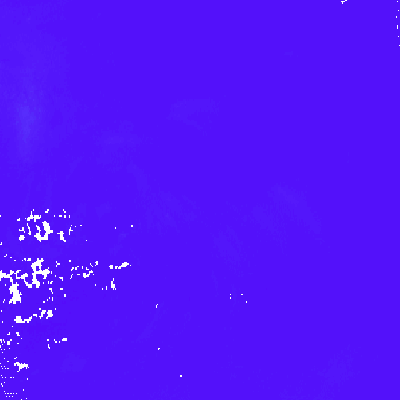

In [11]:
r1

### Prototype worklow using NumPy Arrays

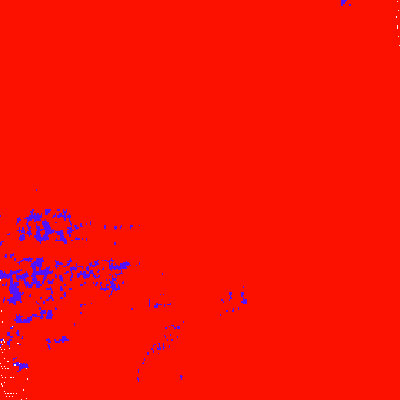

In [12]:
qa1 = qa_19[0]['Raster']
qa1

In [18]:
print(f'Raster dimension in rows x columns: {r1.rows} x {r1.columns}')
npy_r1 = r1.read()
print(f'Numpy array dimension: {npy_r1.shape}')

Raster dimension in rows x columns: 491 x 537
Numpy array dimension: (491, 537, 1)


In [19]:
# flatten to 2D array
npy_r1 = npy_r1[:,:,0]
npy_r1.shape

(491, 537)

In [39]:
print(f'Raster dimension in rows x columns: {qa1.rows} x {qa1.columns}')
npy_qa1 = qa1.read()
print(f'Numpy array dimension: {npy_qa1.shape}')

Raster dimension in rows x columns: 491 x 537
Numpy array dimension: (491, 537, 1)


In [40]:
npy_qa1 = npy_qa1[:,:,0]

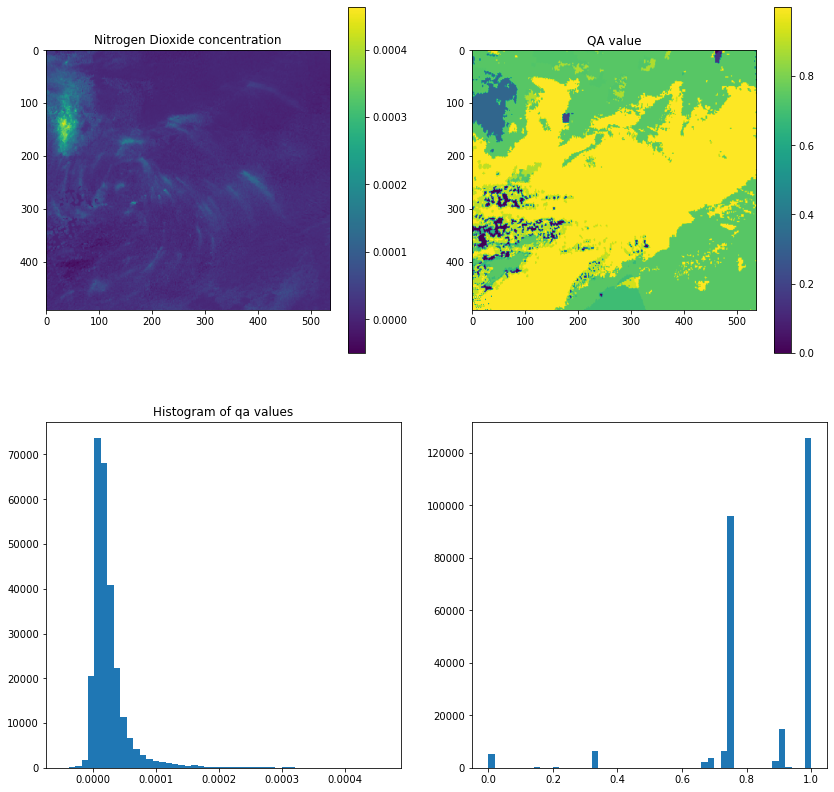

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
axes[0][0].set_title('Nitrogen Dioxide concentration')
im1 = axes[0][0].imshow(npy_r1)
fig.colorbar(im1, ax=axes[0][0])

axes[0][1].set_title('QA value')
im2 = axes[0][1].imshow(npy_qa1)
fig.colorbar(im2, ax=axes[0][1])

axes[1][0].hist(npy_r1.flatten(), bins=50)
axes[1][0].set_title('Histogram of $NO_{2}$ concentration')

axes[1][1].hist(npy_qa1.flatten(), bins=50)
axes[1][0].set_title('Histogram of qa values');

#### Filter only good pixels

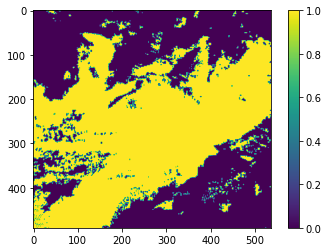

In [83]:
qa_bool_mask = npy_qa1 > 0.75
fig, axes = plt.subplots(1,1)
im = axes.imshow(qa_bool_mask)
fig.colorbar(im, ax=axes);

In [88]:
npy_r1_filtered = npy_r1 * qa_bool_mask
npy_r1_filtered.shape

(491, 537)

In [102]:
npy_r1_pos =  npy_r1_filtered > 0
npy_r1_filtered2 = npy_r1_filtered * npy_r1_pos

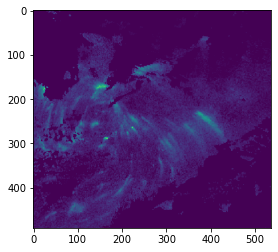

In [103]:
plt.imshow(npy_r1_filtered2)

In [105]:
npy_r1_filtered2.min(), npy_r1_filtered2.max()

(0.0, 0.00023641456209588796)

In [114]:
r1.extent, r1.mean_cell_height, r1.mean_cell_width

({'xmin': -9889507.851225441,
  'ymin': 3810907.1023841263,
  'xmax': -7496237.943900743,
  'ymax': 5999166.924537621,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 4456.740981982679,
 4456.740981982679)

In [154]:
npy_r1_reshaped = npy_r1_filtered2.reshape(491, 537, 1)

In [155]:
npy_r1_reshaped.shape

(491, 537, 1)

In [156]:
r1.write(npy_r1_reshaped)

AttributeError: 'NoneType' object has no attribute 'lower'

In [158]:
r1._engine_obj._raster.format

In [122]:
out_path = r'\\Mac\Home\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\ny_crf\r1.tif'
lower_left_corner = arcpy.Point(r1.extent['xmin'], r1.extent['ymin'])

ras_out = arcpy.NumPyArrayToRaster(npy_r1_filtered2, lower_left_corner, 
                         x_cell_size=r1.mean_cell_width,
                        y_cell_size=r1.mean_cell_height,
                        value_to_nodata=0)
type(ras_out)

arcpy.sa.Raster.Raster

In [124]:
ras_out.save(out_path)

In [11]:
apy_rc = arcpy.ia.RasterCollection(crf_path)

## Map out on all rasters in RC

In [129]:
no2_19[2]

{'Raster': <arcgis.raster._layer.Raster at 0x2603d908c18>,
 'Variable': '/product/nitrogendioxide_tropospheric_column',
 'StdTime': '2019-04-04T00:00:00+00:00'}

In [140]:
qa_19[2]['StdTime'].split('+')

['2019-04-04T00:00:00', '00:00']

In [134]:
qa_19.count

6

In [143]:
qa_19.filter_by_time(no2_19[2]['StdTime'].split('+')[0], no2_19[2]['StdTime'].split('+')[0])

,Raster,Variable,StdTime
0,<arcgis.raster._layer.Raster object at 0x00000...,/product/qa_value,2019-04-04T00:00:00+00:00


In [149]:
def find_valid_cells(item, qa_rc=qa_19):
    no2_ras = item['Raster']
    qa2_rc = qa_rc.filter_by_time(item['StdTime'].split('+')[0], item['StdTime'].split('+')[0])
    qa2_ras = qa2_rc[0]['Raster']
    
    # read to numpy arrays - fills no data with 0
    npy_qa = qa2_ras.read()
    npy_no2 = no2_ras.read()
    
    # find valid cells
    qa_bool_mask = npy_qa >= 0.75
    no2_valid_cells1 = npy_no2 * qa_bool_mask
    no2_pos_mask = no2_valid_cells1 >= 0
    no2_valid_cells2 = no2_valid_cells1 * no2_pos_mask
    
    # write to raster container
    no2_ras.write(array = no2_valid_cells2, value_to_nodata = 0)
    
    # return rc element
    return {'raster': no2_ras, 'StdTime': item['StdTime']}

In [150]:
%%time
no2_processed_rc = no2_19.map(find_valid_cells)

AttributeError: 'NoneType' object has no attribute 'lower'